In [2]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
from eda import *
from processing import *
from scaling import *
from sklearn.pipeline import Pipeline
import joblib
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
# Uncomment for first use
# nltk.download('punkt')
# nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
sns.set_style("whitegrid")

In [12]:
df=pd.read_csv('../data/train.csv')

# Basic Data Overview

In this project we are using Disaster Tweets dataset from Kaggle to determine whether a given tweet informs about a disaster or is just a casual Tweet. 

We have 5 columns:
* **id** : unique tweet id
* **keword** : extracted keyword from a given tweet
* **location** : location from which tweet was sent
* **text** : text of a tweet
* **target** : 0-1 value indicating whether a tweet is fake(0) or real (1)

In [4]:
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [5]:
df.shape

(7613, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
df['keyword'].nunique()

221

In [8]:
df['location'].nunique()

3341

**First observations**
* We have 5 columns and 7613 rows
* We have some missing values in location and keyword column
* We have 221 unique keywords and more than 3000 unique locations
* Locations for the same place are written in different format in some rows

# EDA and Feature Engineering

In [15]:
processing_pipeline = Pipeline([
    
    ('text_feature_extractor', TextFeatureExtractor()),
    ('text_processing', TextProcessing())
])

processing_pipeline.fit_transform(df)
joblib.dump(processing_pipeline, '../pipelines/text_pipeline.joblib')

['../pipelines/text_pipeline.joblib']

In [16]:
#dataframe after all transformations
df

,id,keyword,location,text,target,count_caps_lock,count_exclamation_mark,count_hashtags,count_words,count_punctuation,...,joy,disgust,anticipation,positive,trust,sadness,surprise,processed_text,processed_text_str,mention_god_related
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,0,1,13,1,...,0,0,0,0,0,1,1,"[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive us,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,0,7,1,...,0,0,0,0,0,0,0,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0,0,0,22,3,...,0,0,1,1,1,0,0,"[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0,0,1,8,2,...,0,0,0,0,0,0,0,"[people, receive, wildfire, evacuation, order,...",people receive wildfire evacuation order calif...,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0,0,2,16,2,...,0,0,0,0,1,0,0,"[get, send, photo, ruby, alaska, smoke, wildfi...",get send photo ruby alaska smoke wildfire pour...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,0,0,0,11,5,...,0,0,0,0,0,0,0,"[two, giant, crane, hold, bridge, collapse, ne...",two giant crane hold bridge collapse nearby home,0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,0,0,0,20,4,...,0,0,0,0,0,0,1,"[control, wild, fire, california, even, northe...",control wild fire california even northern par...,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,2,0,0,8,11,...,1,1,0,1,1,1,1,"[volcano, hawaii]",volcano hawaii,0
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,0,0,0,19,5,...,0,1,0,1,0,0,0,"[police, investigate, ebike, collide, car, lit...",police investigate ebike collide car little po...,0


**1. Target Analysis**

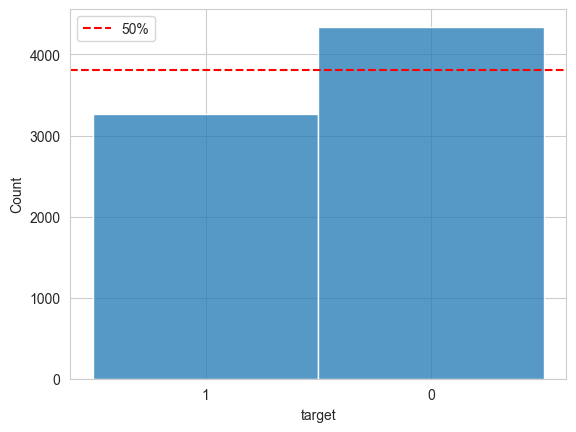

In [17]:
sns.histplot(df['target'].astype(str))
fifty_percent_count = len(df) / 2
plt.axhline(y=fifty_percent_count, color='red', linestyle='--', label='50%')
plt.legend()
plt.show()

In [9]:
target_percentage = df['target'].value_counts(normalize=True) * 100
percentage_table = pd.DataFrame({'Target': target_percentage.index, 'Percentage': target_percentage.values})
percentage_table

,Target,Percentage
0,0,57.034021
1,1,42.965979


There is a slight class imbalance - there are more false tweets

**2. Number of words in caps lock vs target**

In [4]:
pd.set_option('display.max_colwidth', None)

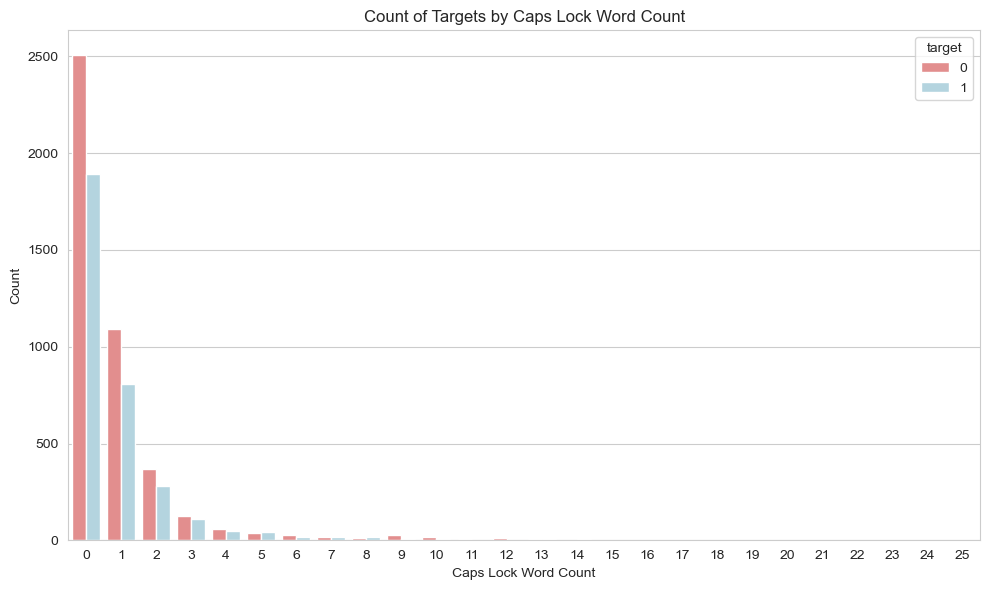

In [12]:
#Caps lock vs target
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='count_caps_lock', hue='target', palette=['lightcoral', 'lightblue'])
plt.xlabel('Caps Lock Word Count')
plt.ylabel('Count')
plt.title('Count of Targets by Caps Lock Word Count')
plt.tight_layout()
plt.show()

We can see that the majority of tweets don't have many words in caps lock. However we can see that the percentage of true tweets increases with the increase of caps lock words - more than 4 caps lock words have 50/50 false and true tweets

**3. Number of '!' vs target**

<Axes: xlabel='count_exclamation_mark', ylabel='count'>

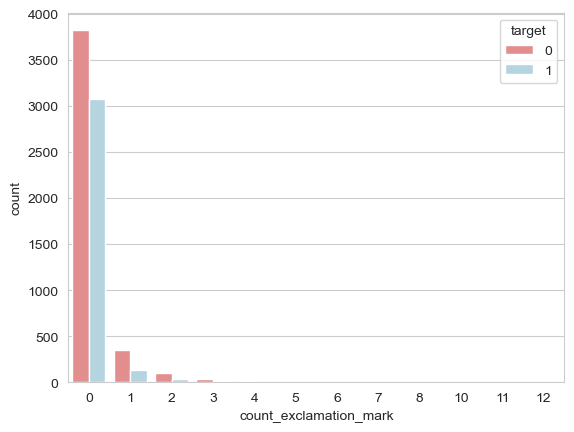

In [13]:
#exclamation marks vs target
sns.countplot(df,x='count_exclamation_mark', hue='target',palette=['lightcoral', 'lightblue'])

In [14]:
pd.crosstab(df['count_exclamation_mark'], df['target'], normalize='index')*100

target,0,1
count_exclamation_mark,,
0,55.395997,44.604003
1,72.594142,27.405858
2,72.727273,27.272727
3,78.846154,21.153846
4,80.000000,20.000000
5,50.000000,50.000000
6,71.428571,28.571429
7,66.666667,33.333333
8,0.000000,100.000000


There is no obvious pattern, most tweets have 0,1,2 exclamation marks

In most groups there are more fake tweets

**4. Number of # vs target**

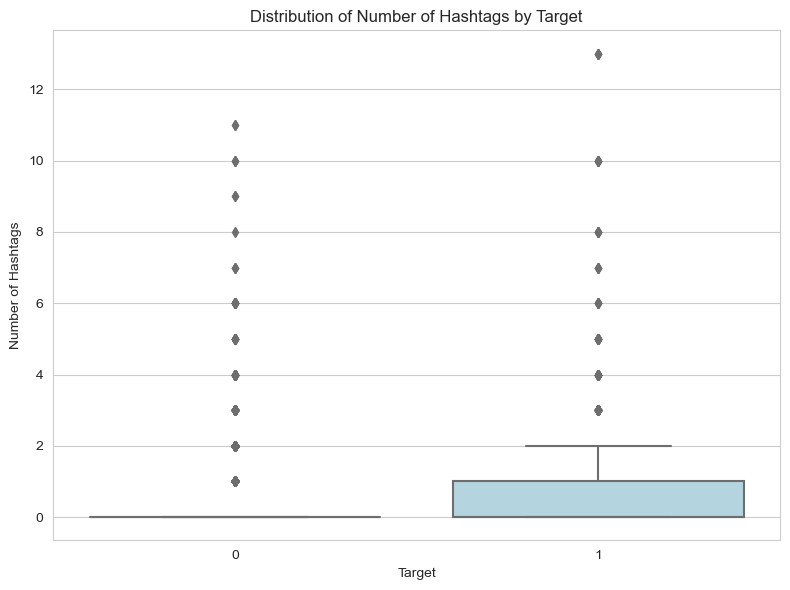

In [15]:
#hashtags vs target
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='target', y='count_hashtags', hue='target', palette=['lightcoral', 'lightblue'], dodge=False)
plt.legend().remove()
plt.xlabel('Target')
plt.ylabel('Number of Hashtags')
plt.title('Distribution of Number of Hashtags by Target')
plt.tight_layout()
plt.show()

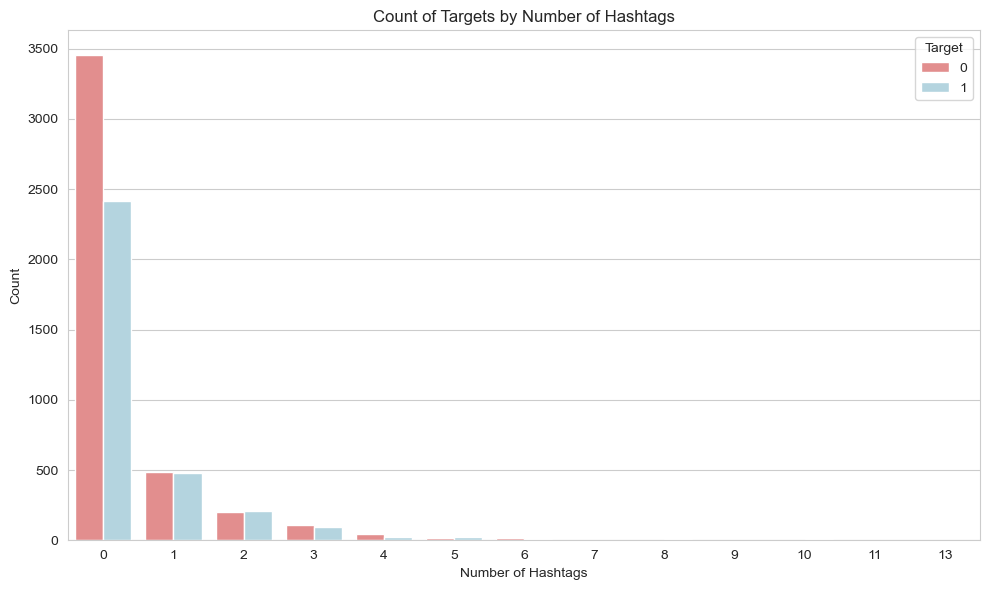

In [16]:

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='count_hashtags', hue='target', palette=['lightcoral', 'lightblue'])
plt.title('Count of Targets by Number of Hashtags')
plt.xlabel('Number of Hashtags')
plt.ylabel('Count')
plt.legend(title='Target', loc='upper right')
plt.tight_layout()
plt.show()

The majority of tweets have 0 hashtags. For 1,2,3 hashtags there are circa 50/50 false and true tweets. If there is no hashtags the tweet is more likely to be false

**5. Number of words vs target**

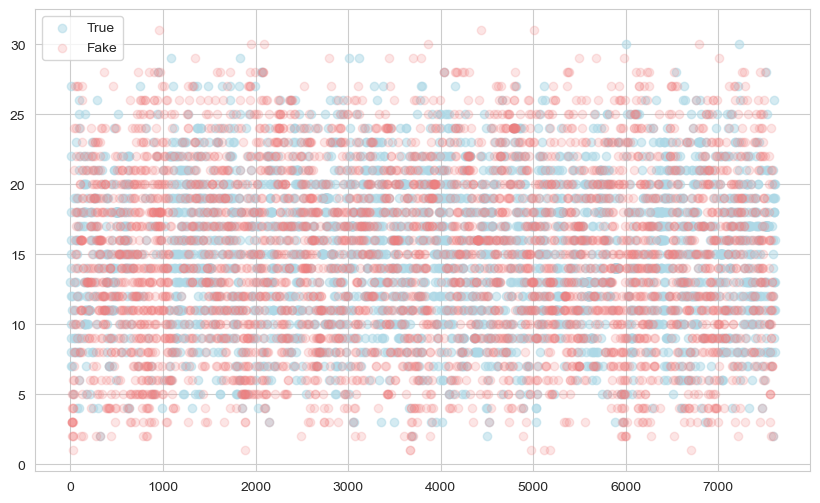

In [17]:
true = df[df['target']==1]
false = df[df['target']==0]

plt.figure(figsize=(10,6))
plt.scatter(true.index, true['count_words'], label='True', color='lightblue',alpha=0.5)
plt.scatter(false.index, false['count_words'], label='Fake', color='lightcoral',alpha=0.2)
plt.legend()
plt.grid(True)
plt.show()

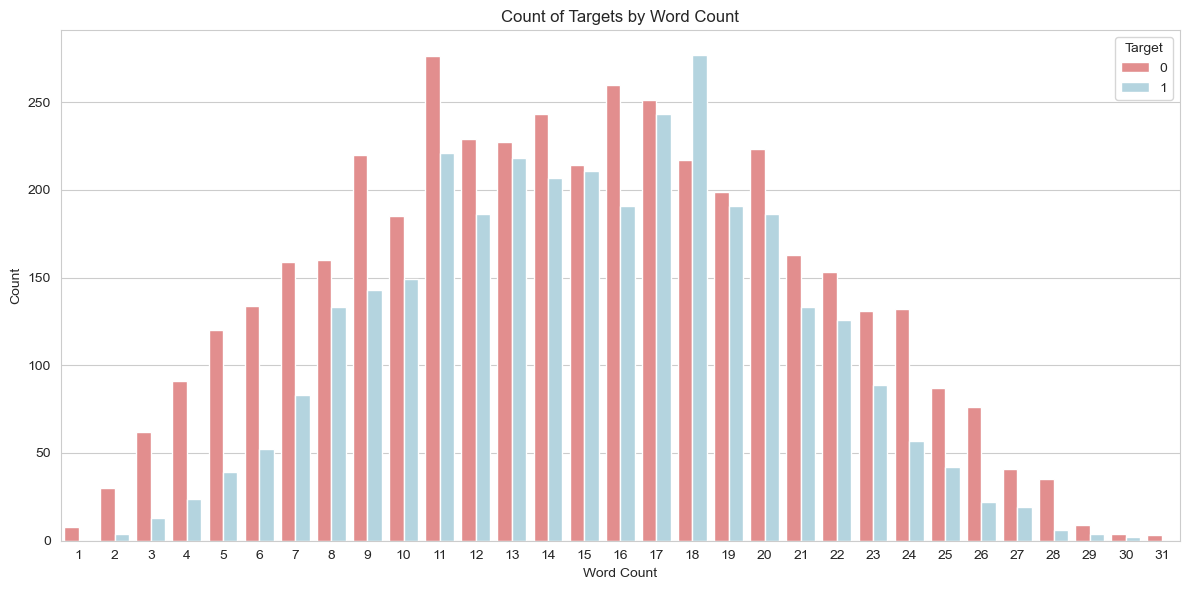

In [18]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='count_words', hue='target', palette=['lightcoral', 'lightblue'])
plt.title('Count of Targets by Word Count')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.legend(title='Target', loc='upper right')
plt.tight_layout()
plt.show()

* there is no visible pattern between number of words and target
* We can only see that if the tweet is very short (1-10 words) or very long (>30 words) it is probably just a casual tweet
* looks like normal distribution

**6. Punctuation vs target**

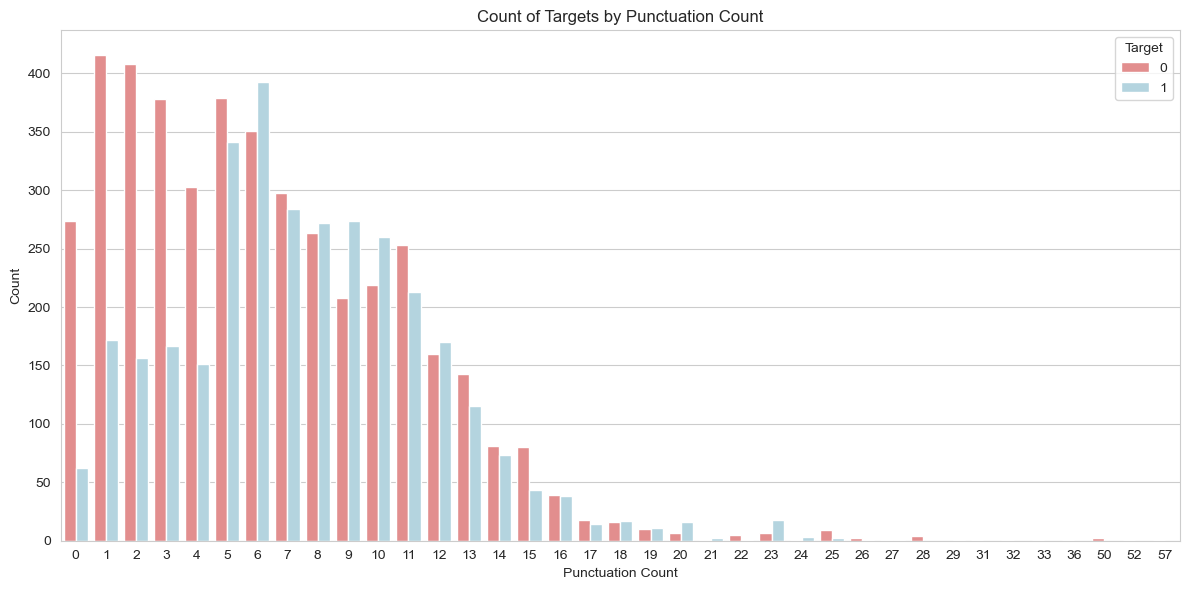

In [19]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='count_punctuation', hue='target', palette=['lightcoral', 'lightblue'])
plt.title('Count of Targets by Punctuation Count')
plt.xlabel('Punctuation Count')
plt.ylabel('Count')
plt.legend(title='Target')
plt.tight_layout()
plt.show()

* we can see a visible pattern : tweets with little punctuation tend to be just casual, and tweets with 6-11 punctuation marks are more likely to be informing about a disaster

**7. Number of links vs target**

<Axes: xlabel='count_links', ylabel='count'>

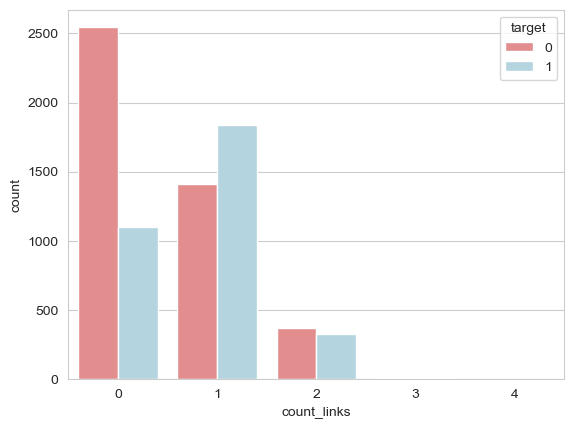

In [20]:
sns.countplot(df, x='count_links', hue='target',palette=['lightcoral', 'lightblue'])

In [21]:
pd.crosstab(df['count_links'], df['target'], normalize='index')*100

target,0,1
count_links,,
0,69.824272,30.175728
1,43.517093,56.482907
2,52.932761,47.067239
3,59.090909,40.909091
4,100.000000,0.000000


Tweets informing about a real danger tend to have more links (most have 1) while casual Tweets mostly don't contain links

**8. Number of stopwords vs target**

<Axes: xlabel='count_stopwords', ylabel='count'>

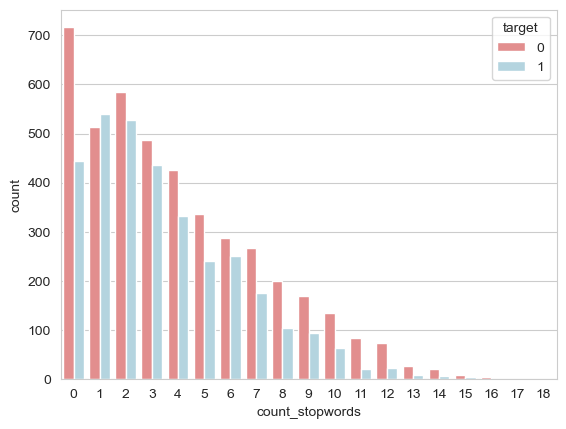

In [22]:
sns.countplot(df, x='count_stopwords', hue='target', palette=['lightcoral', 'lightblue'])

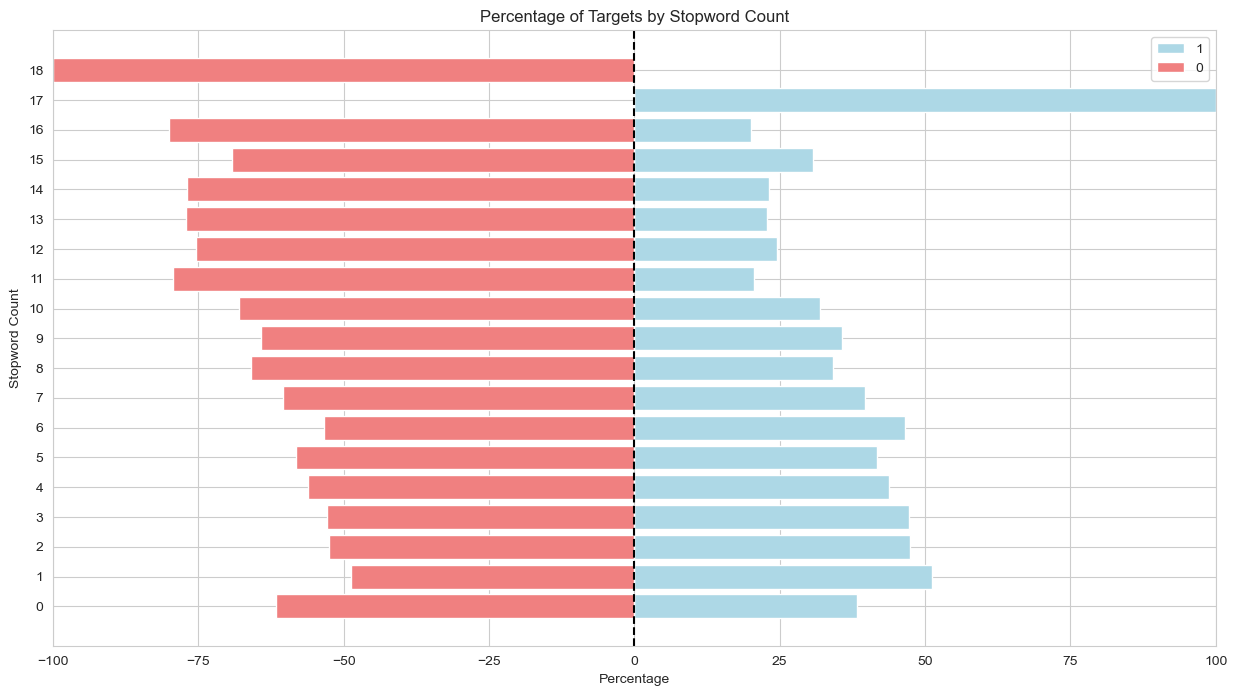

In [23]:
crosstab_normalized = pd.crosstab(df['count_stopwords'], df['target'], normalize='index') * 100

plt.figure(figsize=(15, 8))
legend_added = False
for index, row in crosstab_normalized.iterrows():
    plt.barh(
        str(index),
        row[1],
        color="lightblue",
        label="1" if not legend_added else "",
    )
    plt.barh(
        str(index),
        -row[0],
        color="lightcoral",
        label="0" if not legend_added else "",
    )
    if not legend_added:
        legend_added = True
plt.axvline(x=0, color="black", linestyle="--")
plt.xlabel("Percentage")
plt.ylabel("Stopword Count")
plt.title("Percentage of Targets by Stopword Count")
plt.xlim(-100, 100)
plt.legend(loc="upper right")
plt.show()

* The percent of fake tweets is slightly higer when there are more stop words

**9. Number of mentions vs target**

<Axes: xlabel='count_mentions', ylabel='count'>

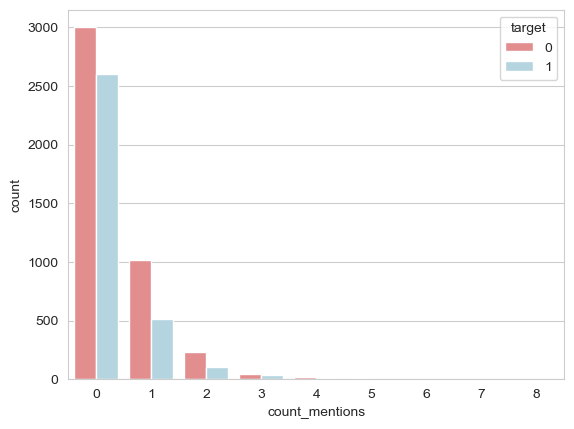

In [24]:
sns.countplot(df, x='count_mentions', hue='target', palette=['lightcoral', 'lightblue'])

**10. Parts of speech vs target**

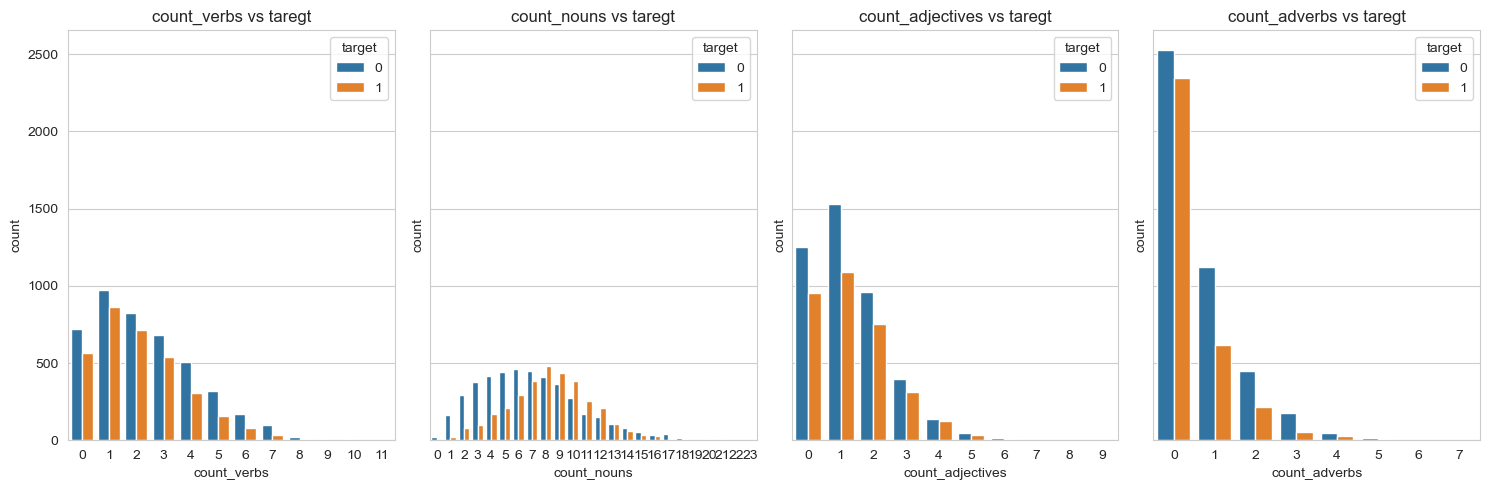

In [6]:
fig, axes = plt.subplots(1,4, figsize =(15,5), sharey=True)
parts = ['count_verbs', 'count_nouns', 'count_adjectives','count_adverbs']

for i,part in enumerate(parts):
    sns.countplot(data=df, x=part, hue='target', ax=axes[i])
    axes[i].set_title(f'{part} vs taregt')

plt.tight_layout()
plt.show()

* for verbs and adverbs there is a right-skewed count distribution for fake and true tweets
* We can see a visible pattern in Noun count : Fake tweets have less nouns that true ones

**Feature correlation**

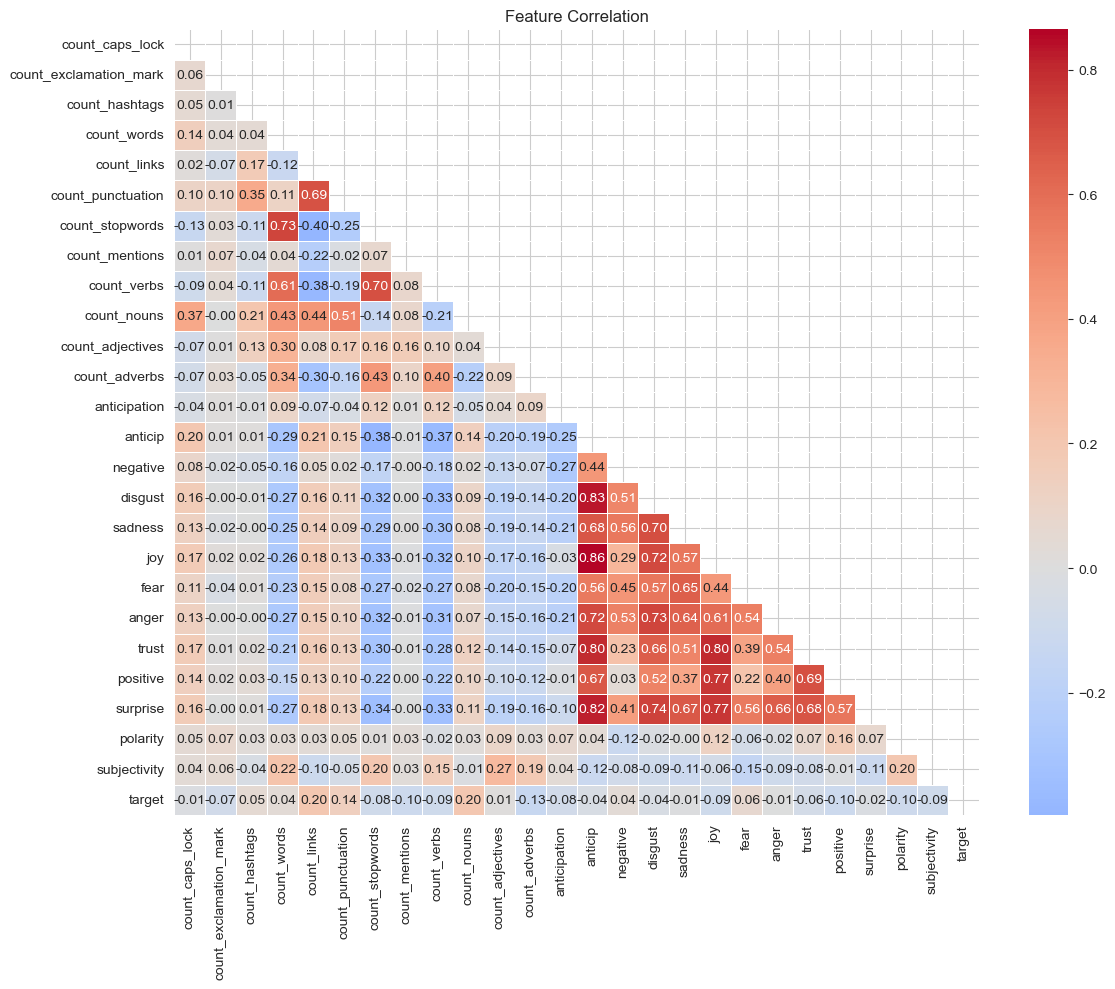

In [18]:
columns = ['count_caps_lock', 'count_exclamation_mark', 'count_hashtags', 
           'count_words', 'count_links', 'count_punctuation', 'count_stopwords','count_mentions','count_verbs','count_nouns','count_adjectives','count_adverbs',
            'anticipation', 'anticip','negative', 'disgust', 'sadness', 'joy', 'fear', 'anger', 'trust','positive', 'surprise','polarity','subjectivity', 'target']
correlation_matrix = df[columns].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, mask=mask, center=0)
plt.title('Feature Correlation')
plt.tight_layout()
plt.show()

We can see that new column like count_links, count_nouns ,count_punctuation and count_adverbs have the biggest correlation with the target

Extracted emotions have a high correlation between each other and very low with the target, so we will probably drop them after EDA

**Location vs target**

In [40]:
print("Percent of tweets with missing location:", round(len(df[df['location'].isna()])*100/len(df),2),"%")

Percent of tweets with missing location: 33.27 %


Locations are redundant : there are values like USA, United States, New York and New York,NY 

In [42]:
df['location'].nunique()

3341

This column will probably be just a noise for our models

**Sentiment analysis**

Every sentence can have a different emotional background. Some tweets can be written in positive, happy, negavite, angry or scared way. In this part we will analyse positive and negative sentiment as well as subjectivity. Then we will move on to extracting more emotions like fear, anger, joy etc

Text(0.5, 1.0, 'Subjectivity vs target')

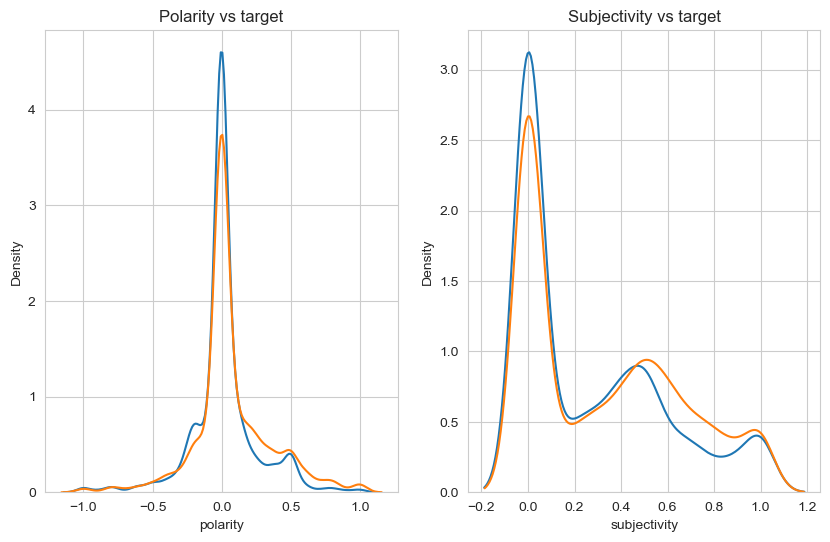

In [21]:
fig, axes = plt.subplots(1,2, figsize=(10,6))
true_tweets = df[df['target']==1]
false_tweets = df[df['target']==0]
sns.kdeplot(data=true_tweets['polarity'],  ax=axes[0])
sns.kdeplot(data=false_tweets['polarity'], ax=axes[0])
sns.kdeplot(data=true_tweets['subjectivity'],  ax=axes[1])
sns.kdeplot(data=false_tweets['subjectivity'], ax=axes[1])
axes[0].set_title("Polarity vs target")
axes[1].set_title("Subjectivity vs target")


Most tweets are neutral (not positive/negative) as well as objective (subjectivity=0)

**God mentions vs target**

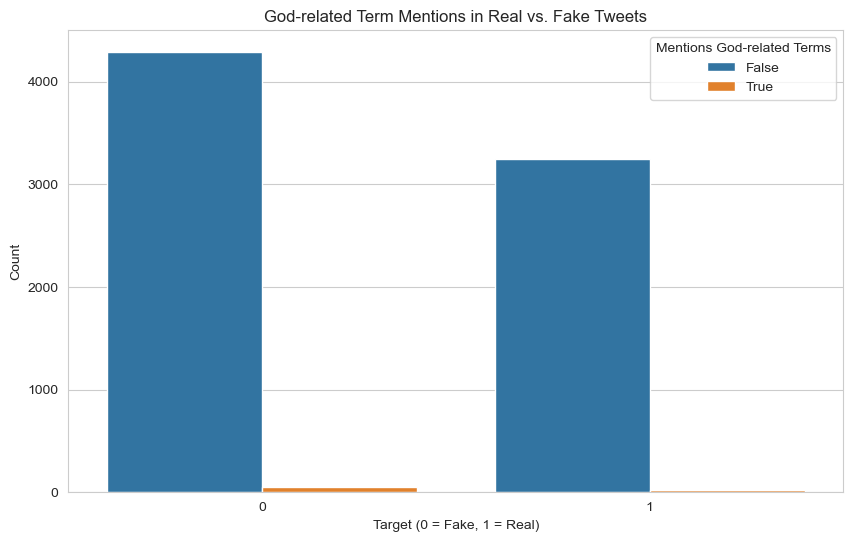

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x='target', hue='mention_god_related', data=df)
plt.xlabel('Target (0 = Fake, 1 = Real)')
plt.ylabel('Count')
plt.title('God-related Term Mentions in Real vs. Fake Tweets')
plt.legend(title='Mentions God-related Terms')
plt.show()

There are more God mentions in casual Tweets

# Visualizing Tokens

(-0.5, 999.5, 807.5, -0.5)

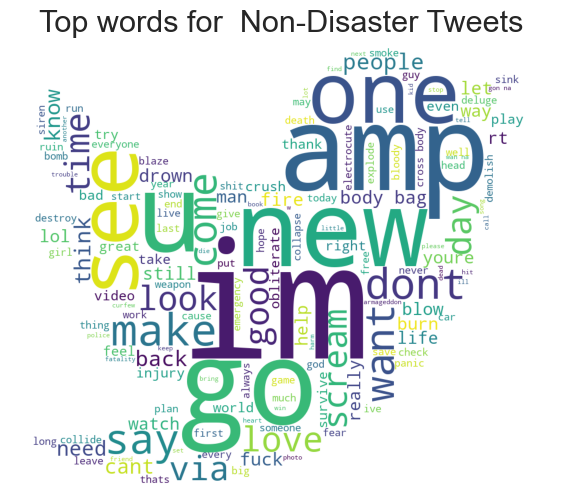

In [7]:
all_words = []
twitter_mask = np.array(Image.open('../img/twitter_mask2.jpg'))
for val in df.loc[df['target'] == 0, 'processed_text']:
     
    all_words.extend(val)

def sentence_maker(words):
    return " ".join(words)
    
all_words = sentence_maker(all_words)

wordcloud = WordCloud(width = 1400, height = 1400,
                background_color ='white',
                min_font_size = 10,
                mask = twitter_mask,
                collocations=True,
                max_words=150).generate(all_words)
plt.figure(figsize = (7, 7), facecolor = None)
plt.title('Top words for  Non-Disaster Tweets', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wordcloud)
plt.axis("off")


(-0.5, 999.5, 807.5, -0.5)

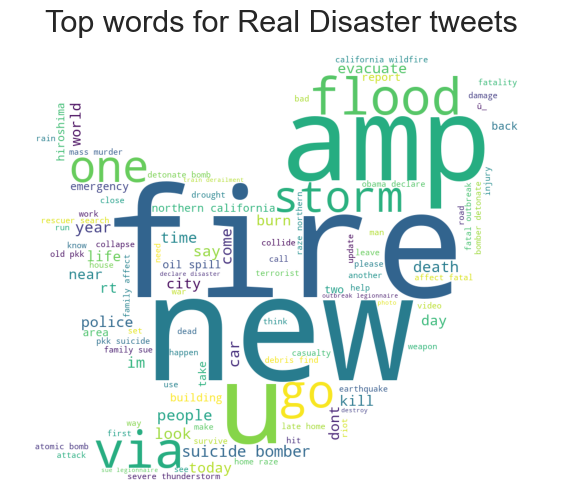

In [8]:
all_words = []
for val in df.loc[df['target'] == 1, 'processed_text']:
     
    all_words.extend(val)

def sentence_maker(words):
    return " ".join(words)
    
all_words = sentence_maker(all_words)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10,
                mask = twitter_mask,
                collocations=True,
                max_words=200).generate(all_words)
plt.figure(figsize = (7, 7), facecolor = None)
plt.title('Top words for Real Disaster tweets', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wordcloud)
plt.axis("off")

Let's use now TfidfVectorizer to check the most important topics of respective tweets.

Let's apply all necessary transformations to get top 5 topics of the tweets and their scores. We will focus on the most unique topics for each tweet.

In [11]:
df['clean_text_1'] = df['text'].apply(clean_text)

# Create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the clean_text column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text_1'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Function to get top n terms with highest TF-IDF scores for each document
def get_top_tfidf_terms(row, features, top_n=5):
    top_terms = row.sort_values(ascending=False).head(top_n)
    return [(term, row[term]) for term in top_terms.index]

# Get the feature names (terms)
features = tfidf_vectorizer.get_feature_names_out()

# Apply the function to each row in the TF-IDF DataFrame
top_tfidf_terms = tfidf_df.apply(lambda row: get_top_tfidf_terms(row, features), axis=1)

# Add the top TF-IDF terms to the original DataFrame
df['top_tfidf_terms'] = top_tfidf_terms

# Display the DataFrame with top TF-IDF terms
print(df[['text', 'top_tfidf_terms']].head())

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                     top_tfidf_terms  
0  [(reason, 0.7472061785445631), (earthquake, 0....  
1  [(la, 0.6312819523963207), (near, 0.5555498401...  
2  [(place, 0.8189269587938204), (expected, 0.439...  
3  [(evacuation, 0.6527054687038003), (california...  
4  [(sent, 0.5066394310979988), (photo, 0.4320518...  


Let's now count top 10 biggest ratios for the whole dataset.

In [12]:
# Aggregate the top terms and their scores
term_scores = defaultdict(float)

for terms in top_tfidf_terms:
    for term, score in terms:
        term_scores[term] += score

# Convert the aggregated scores to a DataFrame
terms_df = pd.DataFrame(term_scores.items(), columns=['term', 'score'])

# Sort the DataFrame by score
terms_df = terms_df.sort_values(by='score', ascending=False)

# Display the top terms
print(terms_df.head(10))


          term      score
28          im  87.796729
76        like  80.291082
298       just  72.413882
135        amp  66.332820
35   emergency  53.720017
89         new  50.913306
573   disaster  48.648297
258       dont  46.358817
12      people  44.707142
724    burning  44.552732


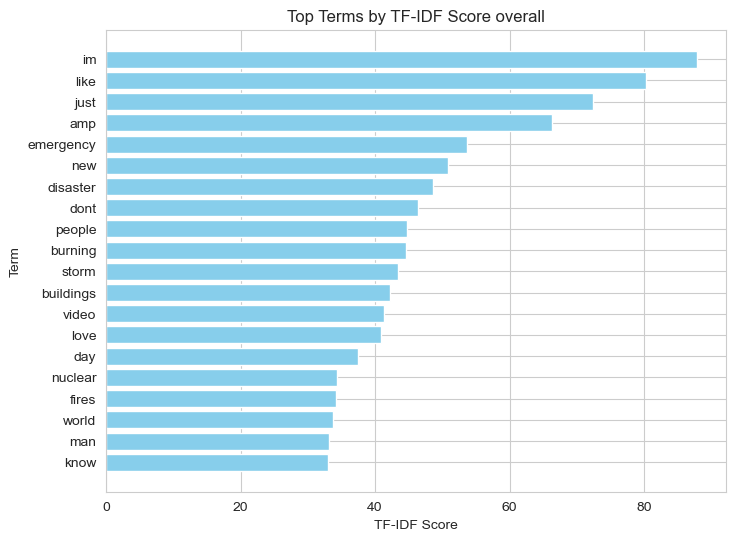

In [13]:
# Plot the top 20 terms as a bar plot
top_n = 20
top_terms_df = terms_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_terms_df['term'], top_terms_df['score'], color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Term')
plt.title('Top Terms by TF-IDF Score overall')
plt.gca().invert_yaxis()
plt.show()

Let's divide it in terms of target and visualize them. Firstly let's focus on real tweets.

In [14]:
# Aggregate the top terms and their scores
term_scores_real = defaultdict(float)

top_tfidf_terms_real=df[df['target']==1]['top_tfidf_terms']

for terms in top_tfidf_terms_real:
    for term, score in terms:
        term_scores_real[term] += score

# Convert the aggregated scores to a DataFrame
real_df = pd.DataFrame(term_scores_real.items(), columns=['term', 'score'])

# Sort the DataFrame by score
real_df = real_df.sort_values(by='score', ascending=False)

# Display the top terms
print(real_df.head(10))

           term      score
375    disaster  34.621943
509   buildings  31.798971
222       storm  30.682784
80        fires  27.455815
510     burning  26.310356
35    emergency  25.825504
1    earthquake  25.422429
283     bombing  25.229714
444   hiroshima  23.826038
13       police  23.272119


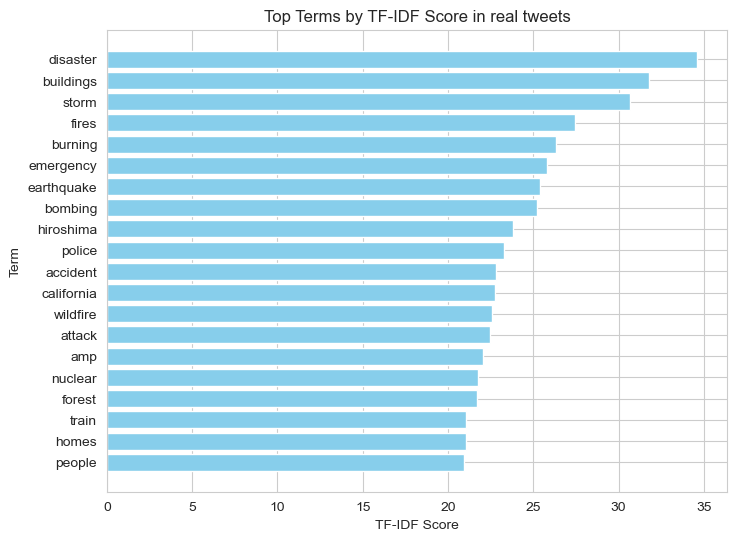

In [15]:
# Plot the top 20 terms as a bar plot
top_n = 20
top_terms_df = real_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_terms_df['term'], top_terms_df['score'], color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Term')
plt.title('Top Terms by TF-IDF Score in real tweets')
plt.gca().invert_yaxis()
plt.show()

Now let's focus on the fake ones.

In [16]:
# Aggregate the top terms and their scores
term_scores_fake = defaultdict(float)

top_tfidf_terms_fake=df[df['target']==0]['top_tfidf_terms']

for terms in top_tfidf_terms_fake:
    for term, score in terms:
        term_scores_fake[term] += score

# Convert the aggregated scores to a DataFrame
fake_df = pd.DataFrame(term_scores_fake.items(), columns=['term', 'score'])

# Sort the DataFrame by score
fake_df = fake_df.sort_values(by='score', ascending=False)

# Display the top terms
print(fake_df.head(10))


          term      score
107         im  74.988511
25        like  61.735854
181       just  57.730348
71         amp  44.282073
38         new  40.775757
5         love  36.867483
321       dont  34.551655
253      video  28.726189
161  emergency  27.894513
176       body  27.618385


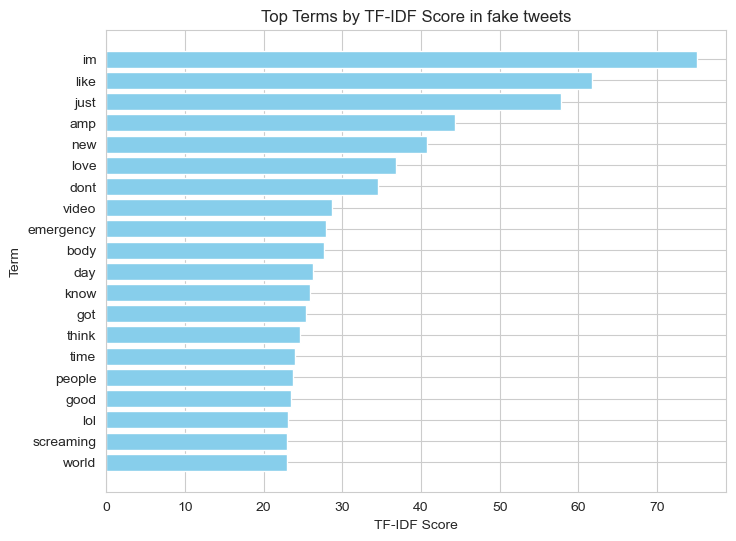

In [17]:
# Plot the top 20 terms as a bar plot
top_n = 20
top_terms_df = fake_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_terms_df['term'], top_terms_df['score'], color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Term')
plt.title('Top Terms by TF-IDF Score in fake tweets')
plt.gca().invert_yaxis()
plt.show()

Let's now focus on bigrams. Let's check, which of them are the most frequent in terms of their appearance in fake and real tweets

In [18]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df['clean_text_1'])

# Sum up the counts of each bigram
bigram_counts = X.toarray().sum(axis=0)
bigram_features = vectorizer.get_feature_names_out()

# Create a DataFrame of bigrams and their counts
bigram_df = pd.DataFrame({'bigram': bigram_features, 'count': bigram_counts})

# Sort the DataFrame by count in descending order to get the most popular bigrams
bigram_df = bigram_df.sort_values(by='count', ascending=False)

# Display the top 10 most popular bigrams
print(bigram_df.head(10))


                    bigram  count
33842       suicide bomber     59
4639     burning buildings     59
20946          liked video     41
24654  northern california     41
25142            oil spill     39
7830            cross body     39
33844      suicide bombing     34
4946   california wildfire     34
21485           looks like     33
22343          mass murder     32


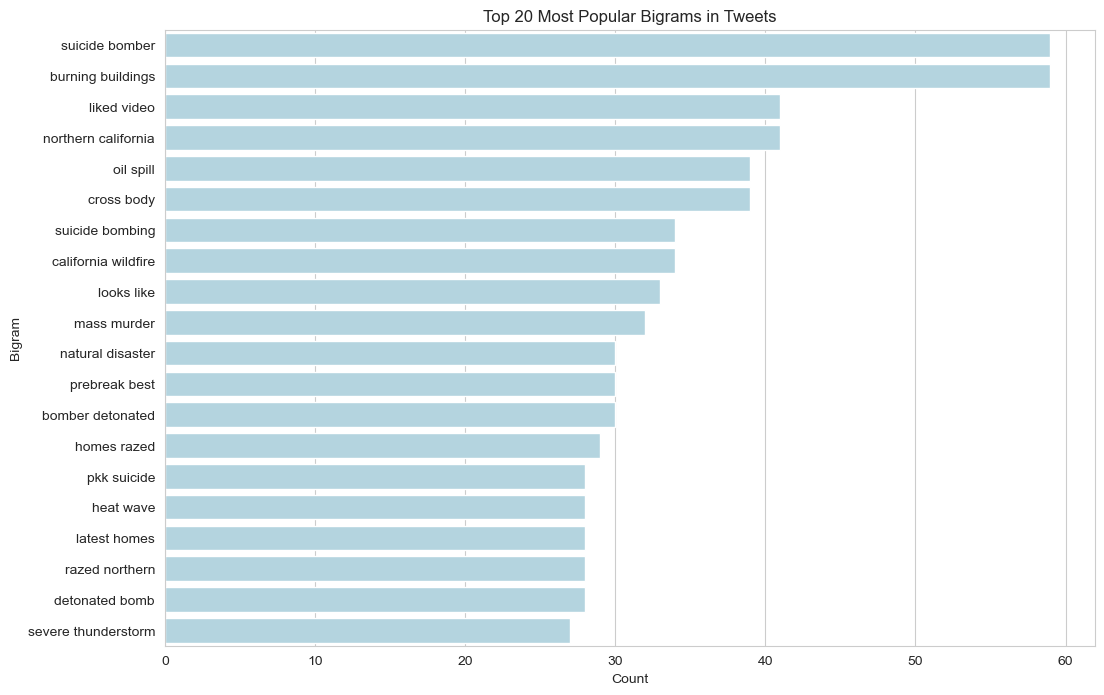

In [19]:
# Plot the top 20 most popular bigrams
top_n = 20
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='bigram', data=bigram_df.head(top_n),color='lightblue')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Top 20 Most Popular Bigrams in Tweets')
plt.show()

We will focus now on the fake tweets

In [20]:
fake_tweets=df[df['target']==0]

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(fake_tweets['clean_text_1'])

# Sum up the counts of each bigram
bigram_counts = X.toarray().sum(axis=0)
bigram_features = vectorizer.get_feature_names_out()

# Create a DataFrame of bigrams and their counts
bigram_df = pd.DataFrame({'bigram': bigram_features, 'count': bigram_counts})

# Sort the DataFrame by count in descending order to get the most popular bigrams
bigram_df = bigram_df.sort_values(by='count', ascending=False)

# Display the top 10 most popular bigrams
print(bigram_df.head(10))

                  bigram  count
4571          cross body     38
12656        liked video     34
2290            body bag     26
2806   burning buildings     23
2292        body bagging     23
17299  reddit quarantine     21
13025         looks like     21
2293           body bags     20
4262      content policy     20
7499           feel like     20


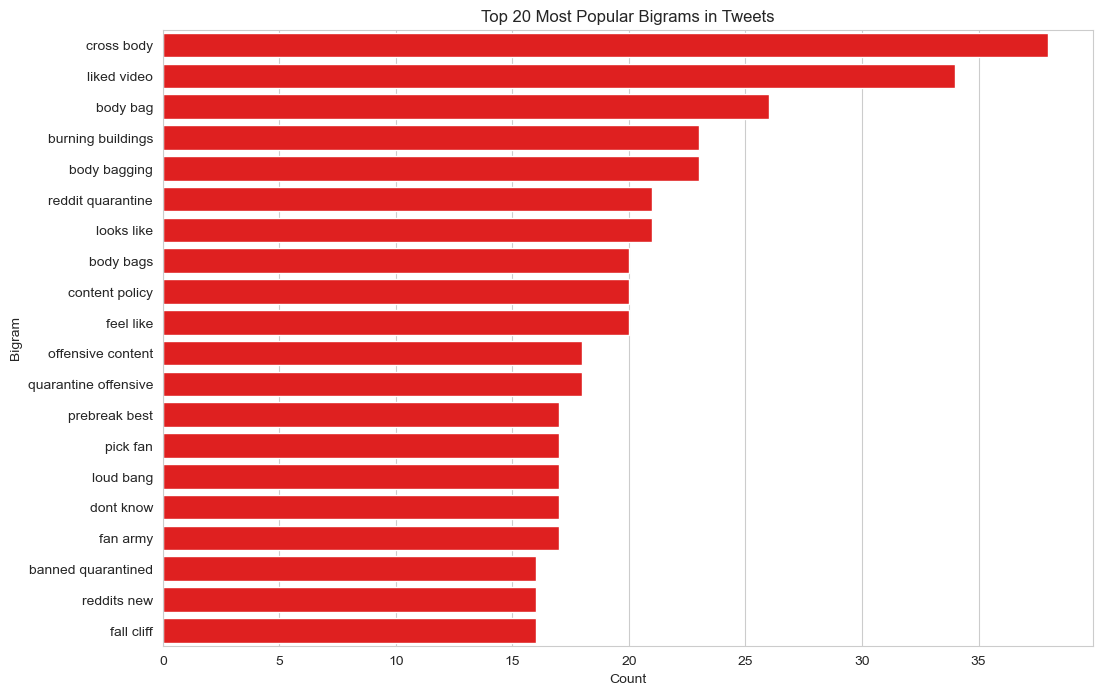

In [21]:
# Plot the top 20 most popular bigrams
top_n = 20
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='bigram', data=bigram_df.head(top_n),color='red')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Top 20 Most Popular Bigrams in Tweets')
plt.show()

We will do the same operations on the real ones

In [22]:
fake_tweets=df[df['target']==1]

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(fake_tweets['clean_text_1'])

# Sum up the counts of each bigram
bigram_counts = X.toarray().sum(axis=0)
bigram_features = vectorizer.get_feature_names_out()

# Create a DataFrame of bigrams and their counts
bigram_df = pd.DataFrame({'bigram': bigram_features, 'count': bigram_counts})

# Sort the DataFrame by count in descending order to get the most popular bigrams
bigram_df = bigram_df.sort_values(by='count', ascending=False)

# Display the top 10 most popular bigrams
print(bigram_df.head(10))

                    bigram  count
14620       suicide bomber     59
10624  northern california     41
10860            oil spill     38
1995     burning buildings     36
14622      suicide bombing     34
2166   california wildfire     34
1631      bomber detonated     30
7292           homes razed     29
12261       razed northern     28
11537          pkk suicide     28


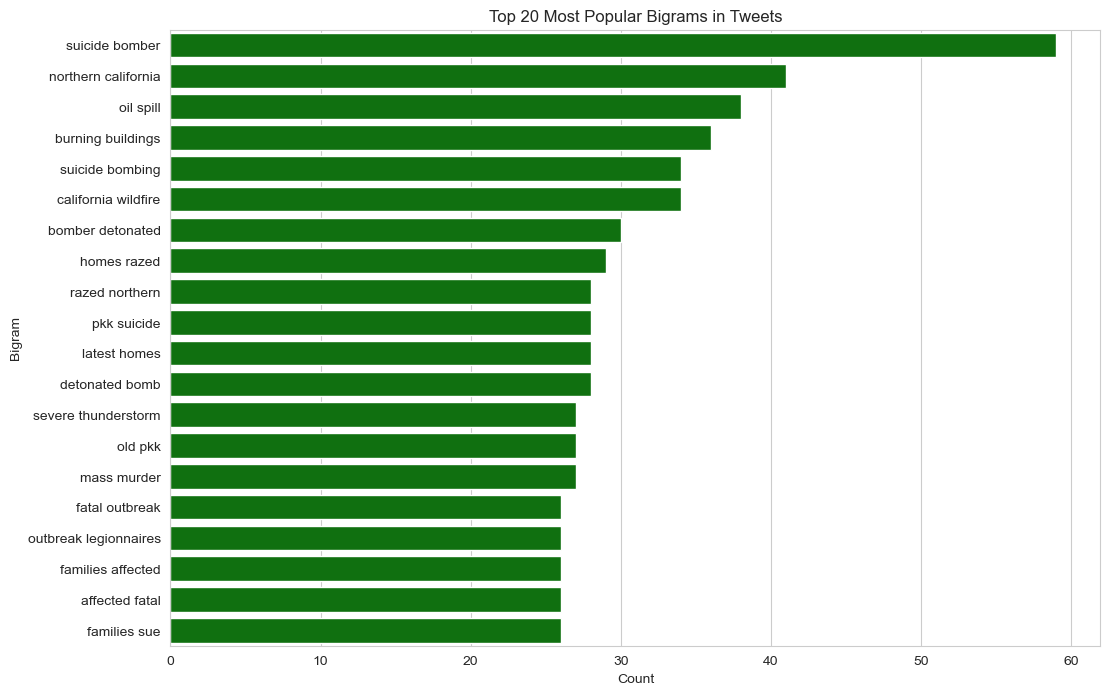

In [23]:
# Plot the top 20 most popular bigrams
top_n = 20
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='bigram', data=bigram_df.head(top_n),color='green')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Top 20 Most Popular Bigrams in Tweets')
plt.show()

Crucial conclusions from EDA and Feature engineering:
* target variable is quite evenly distributed, we don't have class imbalance
* we created some additional features to help us analyse the text, features that turned out to have the biggest correlation with the target are: link count, punctuation count, noun and adverb count
* We explored some keywords and phrases used in both casual and disaster Tweets
* In the next part we will move on to selecting the most relevant features for our models